In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Kr2010.csv', index_col=0)
data_df['sbj'] -= 1

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(tr_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(ts_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2096, 4) (1426, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 1s 843ms/step - loss: 12623.3379
Epoch 2/4000
1/1 [==============================] - 0s 3ms/step - loss: 12559.1689
Epoch 3/4000
1/1 [==============================] - 0s 2ms/step - loss: 12514.1016
Epoch 4/4000
1/1 [==============================] - 0s 2ms/step - loss: 12477.0996
Epoch 5/4000
1/1 [==============================] - 0s 2ms/step - loss: 12444.7529
Epoch 6/4000
1/1 [==============================] - 0s 2ms/step - loss: 12415.4951
Epoch 7/4000
1/1 [==============================] - 0s 3ms/step - loss: 12388.4512
Epoch 8/4000
1/1 [==============================] - 0s 5ms/step - loss: 12363.0645
Epoch 9/4000
1/1 [==============================] - 0s 3ms/step - loss: 12338.9609
Epoch 10/4000
1/1 [==============================] - 0s 3ms/step - loss: 12315.8691
Epoch 11/4000
1/1 [==============================] - 0s 4ms/step - loss: 12293.5967
Epoch 12/4000
1/1 [==============================] - 0s 3ms/step - loss: 12272.0088

1/1 [==============================] - 0s 3ms/step - loss: 11021.6406
Epoch 99/4000
1/1 [==============================] - 0s 4ms/step - loss: 11011.2598
Epoch 100/4000
1/1 [==============================] - 0s 3ms/step - loss: 11000.9463
Epoch 101/4000
1/1 [==============================] - 0s 4ms/step - loss: 10990.7021
Epoch 102/4000
1/1 [==============================] - 0s 3ms/step - loss: 10980.5254
Epoch 103/4000
1/1 [==============================] - 0s 3ms/step - loss: 10970.4160
Epoch 104/4000
1/1 [==============================] - 0s 4ms/step - loss: 10960.3750
Epoch 105/4000
1/1 [==============================] - 0s 3ms/step - loss: 10950.3965
Epoch 106/4000
1/1 [==============================] - 0s 3ms/step - loss: 10940.4834
Epoch 107/4000
1/1 [==============================] - 0s 3ms/step - loss: 10930.6348
Epoch 108/4000
1/1 [==============================] - 0s 4ms/step - loss: 10920.8486
Epoch 109/4000
1/1 [==============================] - 0s 3ms/step - loss: 10911.1

1/1 [==============================] - 0s 3ms/step - loss: 10252.1230
Epoch 195/4000
1/1 [==============================] - 0s 4ms/step - loss: 10245.8008
Epoch 196/4000
1/1 [==============================] - 0s 3ms/step - loss: 10239.5020
Epoch 197/4000
1/1 [==============================] - 0s 3ms/step - loss: 10233.2275
Epoch 198/4000
1/1 [==============================] - 0s 3ms/step - loss: 10226.9766
Epoch 199/4000
1/1 [==============================] - 0s 5ms/step - loss: 10220.7480
Epoch 200/4000
1/1 [==============================] - 0s 3ms/step - loss: 10214.5449
Epoch 201/4000
1/1 [==============================] - 0s 4ms/step - loss: 10208.3652
Epoch 202/4000
1/1 [==============================] - 0s 3ms/step - loss: 10202.2090
Epoch 203/4000
1/1 [==============================] - 0s 4ms/step - loss: 10196.0732
Epoch 204/4000
1/1 [==============================] - 0s 3ms/step - loss: 10189.9609
Epoch 205/4000
1/1 [==============================] - 0s 3ms/step - loss: 10183.

1/1 [==============================] - 0s 3ms/step - loss: 9724.8760
Epoch 292/4000
1/1 [==============================] - 0s 3ms/step - loss: 9719.9521
Epoch 293/4000
1/1 [==============================] - 0s 4ms/step - loss: 9715.0225
Epoch 294/4000
1/1 [==============================] - 0s 3ms/step - loss: 9710.0859
Epoch 295/4000
1/1 [==============================] - 0s 3ms/step - loss: 9705.1396
Epoch 296/4000
1/1 [==============================] - 0s 3ms/step - loss: 9700.1855
Epoch 297/4000
1/1 [==============================] - 0s 4ms/step - loss: 9695.2227
Epoch 298/4000
1/1 [==============================] - 0s 3ms/step - loss: 9690.2490
Epoch 299/4000
1/1 [==============================] - 0s 3ms/step - loss: 9685.2646
Epoch 300/4000
1/1 [==============================] - 0s 3ms/step - loss: 9680.2705
Epoch 301/4000
1/1 [==============================] - 0s 4ms/step - loss: 9675.2637
Epoch 302/4000
1/1 [==============================] - 0s 3ms/step - loss: 9670.2480
Epoch 3

1/1 [==============================] - 0s 4ms/step - loss: 9197.9277
Epoch 389/4000
1/1 [==============================] - 0s 3ms/step - loss: 9192.6553
Epoch 390/4000
1/1 [==============================] - 0s 4ms/step - loss: 9187.3945
Epoch 391/4000
1/1 [==============================] - 0s 4ms/step - loss: 9182.1455
Epoch 392/4000
1/1 [==============================] - 0s 3ms/step - loss: 9176.9072
Epoch 393/4000
1/1 [==============================] - 0s 3ms/step - loss: 9171.6816
Epoch 394/4000
1/1 [==============================] - 0s 4ms/step - loss: 9166.4648
Epoch 395/4000
1/1 [==============================] - 0s 3ms/step - loss: 9161.2598
Epoch 396/4000
1/1 [==============================] - 0s 3ms/step - loss: 9156.0625
Epoch 397/4000
1/1 [==============================] - 0s 3ms/step - loss: 9150.8760
Epoch 398/4000
1/1 [==============================] - 0s 4ms/step - loss: 9145.6992
Epoch 399/4000
1/1 [==============================] - 0s 3ms/step - loss: 9140.5303
Epoch 4

1/1 [==============================] - 0s 4ms/step - loss: 8545.0605
Epoch 486/4000
1/1 [==============================] - 0s 3ms/step - loss: 8537.8652
Epoch 487/4000
1/1 [==============================] - 0s 3ms/step - loss: 8530.7695
Epoch 488/4000
1/1 [==============================] - 0s 3ms/step - loss: 8523.7617
Epoch 489/4000
1/1 [==============================] - 0s 4ms/step - loss: 8516.8340
Epoch 490/4000
1/1 [==============================] - 0s 3ms/step - loss: 8509.9814
Epoch 491/4000
1/1 [==============================] - 0s 3ms/step - loss: 8503.1943
Epoch 492/4000
1/1 [==============================] - 0s 3ms/step - loss: 8496.4678
Epoch 493/4000
1/1 [==============================] - 0s 4ms/step - loss: 8489.7969
Epoch 494/4000
1/1 [==============================] - 0s 3ms/step - loss: 8483.1777
Epoch 495/4000
1/1 [==============================] - 0s 3ms/step - loss: 8476.6064
Epoch 496/4000
1/1 [==============================] - 0s 3ms/step - loss: 8470.0771
Epoch 4

1/1 [==============================] - 0s 3ms/step - loss: 7971.1045
Epoch 583/4000
1/1 [==============================] - 0s 3ms/step - loss: 7965.7168
Epoch 584/4000
1/1 [==============================] - 0s 3ms/step - loss: 7960.3325
Epoch 585/4000
1/1 [==============================] - 0s 4ms/step - loss: 7954.9585
Epoch 586/4000
1/1 [==============================] - 0s 3ms/step - loss: 7949.5908
Epoch 587/4000
1/1 [==============================] - 0s 3ms/step - loss: 7944.2334
Epoch 588/4000
1/1 [==============================] - 0s 3ms/step - loss: 7938.8833
Epoch 589/4000
1/1 [==============================] - 0s 4ms/step - loss: 7933.5439
Epoch 590/4000
1/1 [==============================] - 0s 3ms/step - loss: 7928.2114
Epoch 591/4000
1/1 [==============================] - 0s 3ms/step - loss: 7922.8906
Epoch 592/4000
1/1 [==============================] - 0s 3ms/step - loss: 7917.5713
Epoch 593/4000
1/1 [==============================] - 0s 4ms/step - loss: 7912.2637
Epoch 5

1/1 [==============================] - 0s 6ms/step - loss: 7491.6470
Epoch 680/4000
1/1 [==============================] - 0s 4ms/step - loss: 7487.2393
Epoch 681/4000
1/1 [==============================] - 0s 6ms/step - loss: 7482.8628
Epoch 682/4000
1/1 [==============================] - 0s 6ms/step - loss: 7478.4751
Epoch 683/4000
1/1 [==============================] - 0s 5ms/step - loss: 7474.1201
Epoch 684/4000
1/1 [==============================] - 0s 6ms/step - loss: 7469.7524
Epoch 685/4000
1/1 [==============================] - 0s 4ms/step - loss: 7465.4160
Epoch 686/4000
1/1 [==============================] - 0s 5ms/step - loss: 7461.0684
Epoch 687/4000
1/1 [==============================] - 0s 5ms/step - loss: 7456.7520
Epoch 688/4000
1/1 [==============================] - 0s 5ms/step - loss: 7452.4238
Epoch 689/4000
1/1 [==============================] - 0s 6ms/step - loss: 7448.1270
Epoch 690/4000
1/1 [==============================] - 0s 5ms/step - loss: 7443.8179
Epoch 6

1/1 [==============================] - 0s 4ms/step - loss: 7103.5479
Epoch 777/4000
1/1 [==============================] - 0s 4ms/step - loss: 7099.8984
Epoch 778/4000
1/1 [==============================] - 0s 3ms/step - loss: 7096.2373
Epoch 779/4000
1/1 [==============================] - 0s 4ms/step - loss: 7092.5996
Epoch 780/4000
1/1 [==============================] - 0s 4ms/step - loss: 7088.9561
Epoch 781/4000
1/1 [==============================] - 0s 3ms/step - loss: 7085.3296
Epoch 782/4000
1/1 [==============================] - 0s 3ms/step - loss: 7081.7031
Epoch 783/4000
1/1 [==============================] - 0s 4ms/step - loss: 7078.0830
Epoch 784/4000
1/1 [==============================] - 0s 3ms/step - loss: 7074.4658
Epoch 785/4000
1/1 [==============================] - 0s 3ms/step - loss: 7070.8594
Epoch 786/4000
1/1 [==============================] - 0s 3ms/step - loss: 7067.2544
Epoch 787/4000
1/1 [==============================] - 0s 4ms/step - loss: 7063.6680
Epoch 7

1/1 [==============================] - 0s 4ms/step - loss: 6777.7695
Epoch 874/4000
1/1 [==============================] - 0s 3ms/step - loss: 6774.7090
Epoch 875/4000
1/1 [==============================] - 0s 3ms/step - loss: 6771.6479
Epoch 876/4000
1/1 [==============================] - 0s 3ms/step - loss: 6768.5991
Epoch 877/4000
1/1 [==============================] - 0s 4ms/step - loss: 6765.5469
Epoch 878/4000
1/1 [==============================] - 0s 3ms/step - loss: 6762.5112
Epoch 879/4000
1/1 [==============================] - 0s 3ms/step - loss: 6759.4761
Epoch 880/4000
1/1 [==============================] - 0s 3ms/step - loss: 6756.4531
Epoch 881/4000
1/1 [==============================] - 0s 3ms/step - loss: 6753.4365
Epoch 882/4000
1/1 [==============================] - 0s 3ms/step - loss: 6750.4219
Epoch 883/4000
1/1 [==============================] - 0s 3ms/step - loss: 6747.4189
Epoch 884/4000
1/1 [==============================] - 0s 3ms/step - loss: 6744.4082
Epoch 8

1/1 [==============================] - 0s 6ms/step - loss: 6506.5503
Epoch 971/4000
1/1 [==============================] - 0s 6ms/step - loss: 6504.0049
Epoch 972/4000
1/1 [==============================] - 0s 5ms/step - loss: 6501.4761
Epoch 973/4000
1/1 [==============================] - 0s 6ms/step - loss: 6498.9438
Epoch 974/4000
1/1 [==============================] - 0s 4ms/step - loss: 6496.4238
Epoch 975/4000
1/1 [==============================] - 0s 6ms/step - loss: 6493.9028
Epoch 976/4000
1/1 [==============================] - 0s 5ms/step - loss: 6491.3916
Epoch 977/4000
1/1 [==============================] - 0s 5ms/step - loss: 6488.8813
Epoch 978/4000
1/1 [==============================] - 0s 6ms/step - loss: 6486.3799
Epoch 979/4000
1/1 [==============================] - 0s 5ms/step - loss: 6483.8789
Epoch 980/4000
1/1 [==============================] - 0s 6ms/step - loss: 6481.3877
Epoch 981/4000
1/1 [==============================] - 0s 4ms/step - loss: 6478.8965
Epoch 9

1/1 [==============================] - 0s 3ms/step - loss: 6285.2422
Epoch 1067/4000
1/1 [==============================] - 0s 3ms/step - loss: 6283.1748
Epoch 1068/4000
1/1 [==============================] - 0s 3ms/step - loss: 6281.1025
Epoch 1069/4000
1/1 [==============================] - 0s 3ms/step - loss: 6279.0439
Epoch 1070/4000
1/1 [==============================] - 0s 3ms/step - loss: 6276.9844
Epoch 1071/4000
1/1 [==============================] - 0s 4ms/step - loss: 6274.9341
Epoch 1072/4000
1/1 [==============================] - 0s 4ms/step - loss: 6272.8862
Epoch 1073/4000
1/1 [==============================] - 0s 3ms/step - loss: 6270.8428
Epoch 1074/4000
1/1 [==============================] - 0s 3ms/step - loss: 6268.8037
Epoch 1075/4000
1/1 [==============================] - 0s 4ms/step - loss: 6266.7705
Epoch 1076/4000
1/1 [==============================] - 0s 3ms/step - loss: 6264.7402
Epoch 1077/4000
1/1 [==============================] - 0s 3ms/step - loss: 6262.7

1/1 [==============================] - 0s 3ms/step - loss: 6108.1787
Epoch 1163/4000
1/1 [==============================] - 0s 4ms/step - loss: 6106.5713
Epoch 1164/4000
1/1 [==============================] - 0s 3ms/step - loss: 6104.9600
Epoch 1165/4000
1/1 [==============================] - 0s 3ms/step - loss: 6103.3584
Epoch 1166/4000
1/1 [==============================] - 0s 3ms/step - loss: 6101.7568
Epoch 1167/4000
1/1 [==============================] - 0s 3ms/step - loss: 6100.1567
Epoch 1168/4000
1/1 [==============================] - 0s 3ms/step - loss: 6098.5615
Epoch 1169/4000
1/1 [==============================] - 0s 3ms/step - loss: 6096.9761
Epoch 1170/4000
1/1 [==============================] - 0s 3ms/step - loss: 6095.3921
Epoch 1171/4000
1/1 [==============================] - 0s 4ms/step - loss: 6093.8237
Epoch 1172/4000
1/1 [==============================] - 0s 3ms/step - loss: 6092.2432
Epoch 1173/4000
1/1 [==============================] - 0s 4ms/step - loss: 6090.6

1/1 [==============================] - 0s 3ms/step - loss: 5973.2734
Epoch 1259/4000
1/1 [==============================] - 0s 5ms/step - loss: 5972.0962
Epoch 1260/4000
1/1 [==============================] - 0s 4ms/step - loss: 5970.8809
Epoch 1261/4000
1/1 [==============================] - 0s 3ms/step - loss: 5969.7012
Epoch 1262/4000
1/1 [==============================] - 0s 4ms/step - loss: 5968.5015
Epoch 1263/4000
1/1 [==============================] - 0s 3ms/step - loss: 5967.2959
Epoch 1264/4000
1/1 [==============================] - 0s 3ms/step - loss: 5966.0898
Epoch 1265/4000
1/1 [==============================] - 0s 3ms/step - loss: 5964.8936
Epoch 1266/4000
1/1 [==============================] - 0s 4ms/step - loss: 5963.6948
Epoch 1267/4000
1/1 [==============================] - 0s 3ms/step - loss: 5962.5352
Epoch 1268/4000
1/1 [==============================] - 0s 3ms/step - loss: 5961.3428
Epoch 1269/4000
1/1 [==============================] - 0s 3ms/step - loss: 5960.2

1/1 [==============================] - 0s 6ms/step - loss: 5872.7505
Epoch 1355/4000
1/1 [==============================] - 0s 5ms/step - loss: 5871.8809
Epoch 1356/4000
1/1 [==============================] - 0s 6ms/step - loss: 5870.9604
Epoch 1357/4000
1/1 [==============================] - 0s 6ms/step - loss: 5870.0864
Epoch 1358/4000
1/1 [==============================] - 0s 5ms/step - loss: 5869.1538
Epoch 1359/4000
1/1 [==============================] - 0s 6ms/step - loss: 5868.2910
Epoch 1360/4000
1/1 [==============================] - 0s 4ms/step - loss: 5867.3652
Epoch 1361/4000
1/1 [==============================] - 0s 5ms/step - loss: 5866.5430
Epoch 1362/4000
1/1 [==============================] - 0s 5ms/step - loss: 5865.6045
Epoch 1363/4000
1/1 [==============================] - 0s 5ms/step - loss: 5864.8008
Epoch 1364/4000
1/1 [==============================] - 0s 6ms/step - loss: 5863.8516
Epoch 1365/4000
1/1 [==============================] - 0s 5ms/step - loss: 5863.0

1/1 [==============================] - 0s 4ms/step - loss: 5797.6523
Epoch 1451/4000
1/1 [==============================] - 0s 4ms/step - loss: 5797.0107
Epoch 1452/4000
1/1 [==============================] - 0s 4ms/step - loss: 5796.2676
Epoch 1453/4000
1/1 [==============================] - 0s 4ms/step - loss: 5795.7129
Epoch 1454/4000
1/1 [==============================] - 0s 4ms/step - loss: 5794.9795
Epoch 1455/4000
1/1 [==============================] - 0s 4ms/step - loss: 5794.4209
Epoch 1456/4000
1/1 [==============================] - 0s 4ms/step - loss: 5793.6245
Epoch 1457/4000
1/1 [==============================] - 0s 4ms/step - loss: 5793.0684
Epoch 1458/4000
1/1 [==============================] - 0s 3ms/step - loss: 5792.2808
Epoch 1459/4000
1/1 [==============================] - 0s 4ms/step - loss: 5791.6919
Epoch 1460/4000
1/1 [==============================] - 0s 4ms/step - loss: 5790.9829
Epoch 1461/4000
1/1 [==============================] - 0s 3ms/step - loss: 5790.4

1/1 [==============================] - 0s 4ms/step - loss: 5741.0391
Epoch 1547/4000
1/1 [==============================] - 0s 5ms/step - loss: 5740.6567
Epoch 1548/4000
1/1 [==============================] - 0s 5ms/step - loss: 5740.0269
Epoch 1549/4000
1/1 [==============================] - 0s 4ms/step - loss: 5739.6089
Epoch 1550/4000
1/1 [==============================] - 0s 6ms/step - loss: 5738.9131
Epoch 1551/4000
1/1 [==============================] - 0s 5ms/step - loss: 5738.4761
Epoch 1552/4000
1/1 [==============================] - 0s 4ms/step - loss: 5737.8789
Epoch 1553/4000
1/1 [==============================] - 0s 5ms/step - loss: 5737.5234
Epoch 1554/4000
1/1 [==============================] - 0s 5ms/step - loss: 5737.0713
Epoch 1555/4000
1/1 [==============================] - 0s 5ms/step - loss: 5736.5371
Epoch 1556/4000
1/1 [==============================] - 0s 6ms/step - loss: 5736.0410
Epoch 1557/4000
1/1 [==============================] - 0s 5ms/step - loss: 5735.5

1/1 [==============================] - 0s 3ms/step - loss: 5697.0645
Epoch 1643/4000
1/1 [==============================] - 0s 5ms/step - loss: 5696.7920
Epoch 1644/4000
1/1 [==============================] - 0s 4ms/step - loss: 5696.1294
Epoch 1645/4000
1/1 [==============================] - 0s 3ms/step - loss: 5695.8848
Epoch 1646/4000
1/1 [==============================] - 0s 4ms/step - loss: 5695.5146
Epoch 1647/4000
1/1 [==============================] - 0s 4ms/step - loss: 5695.1748
Epoch 1648/4000
1/1 [==============================] - 0s 3ms/step - loss: 5694.7847
Epoch 1649/4000
1/1 [==============================] - 0s 3ms/step - loss: 5694.3750
Epoch 1650/4000
1/1 [==============================] - 0s 4ms/step - loss: 5693.8345
Epoch 1651/4000
1/1 [==============================] - 0s 3ms/step - loss: 5693.4253
Epoch 1652/4000
1/1 [==============================] - 0s 3ms/step - loss: 5692.9180
Epoch 1653/4000
1/1 [==============================] - 0s 3ms/step - loss: 5692.6

1/1 [==============================] - 0s 7ms/step - loss: 5661.2246
Epoch 1739/4000
1/1 [==============================] - 0s 6ms/step - loss: 5661.2734
Epoch 1740/4000
1/1 [==============================] - 0s 6ms/step - loss: 5660.9424
Epoch 1741/4000
1/1 [==============================] - 0s 7ms/step - loss: 5660.5093
Epoch 1742/4000
1/1 [==============================] - 0s 7ms/step - loss: 5660.1519
Epoch 1743/4000
1/1 [==============================] - 0s 8ms/step - loss: 5659.5688
Epoch 1744/4000
1/1 [==============================] - 0s 6ms/step - loss: 5659.1323
Epoch 1745/4000
1/1 [==============================] - 0s 7ms/step - loss: 5658.8716
Epoch 1746/4000
1/1 [==============================] - 0s 7ms/step - loss: 5658.7090
Epoch 1747/4000
1/1 [==============================] - 0s 6ms/step - loss: 5658.7412
Epoch 1748/4000
1/1 [==============================] - 0s 6ms/step - loss: 5658.3711
Epoch 1749/4000
1/1 [==============================] - 0s 6ms/step - loss: 5658.1

1/1 [==============================] - 0s 5ms/step - loss: 5632.8457
Epoch 1835/4000
1/1 [==============================] - 0s 5ms/step - loss: 5632.5923
Epoch 1836/4000
1/1 [==============================] - 0s 10ms/step - loss: 5632.2944
Epoch 1837/4000
1/1 [==============================] - 0s 8ms/step - loss: 5631.7207
Epoch 1838/4000
1/1 [==============================] - 0s 6ms/step - loss: 5631.2354
Epoch 1839/4000
1/1 [==============================] - 0s 4ms/step - loss: 5631.2119
Epoch 1840/4000
1/1 [==============================] - 0s 4ms/step - loss: 5630.7891
Epoch 1841/4000
1/1 [==============================] - 0s 5ms/step - loss: 5630.8018
Epoch 1842/4000
1/1 [==============================] - 0s 4ms/step - loss: 5630.6006
Epoch 1843/4000
1/1 [==============================] - 0s 4ms/step - loss: 5630.6201
Epoch 1844/4000
1/1 [==============================] - 0s 4ms/step - loss: 5629.7827
Epoch 1845/4000
1/1 [==============================] - 0s 5ms/step - loss: 5629.

1/1 [==============================] - 0s 4ms/step - loss: 5608.3223
Epoch 1931/4000
1/1 [==============================] - 0s 4ms/step - loss: 5608.5049
Epoch 1932/4000
1/1 [==============================] - 0s 5ms/step - loss: 5608.1943
Epoch 1933/4000
1/1 [==============================] - 0s 4ms/step - loss: 5608.2471
Epoch 1934/4000
1/1 [==============================] - 0s 4ms/step - loss: 5608.1787
Epoch 1935/4000
1/1 [==============================] - 0s 5ms/step - loss: 5607.5327
Epoch 1936/4000
1/1 [==============================] - 0s 4ms/step - loss: 5606.9961
Epoch 1937/4000
1/1 [==============================] - 0s 4ms/step - loss: 5606.8706
Epoch 1938/4000
1/1 [==============================] - 0s 5ms/step - loss: 5606.2080
Epoch 1939/4000
1/1 [==============================] - 0s 4ms/step - loss: 5607.1533
Epoch 1940/4000
1/1 [==============================] - 0s 4ms/step - loss: 5607.1777
Epoch 1941/4000
1/1 [==============================] - 0s 5ms/step - loss: 5607.4

1/1 [==============================] - 0s 5ms/step - loss: 5593.7456
Epoch 2027/4000
1/1 [==============================] - 0s 6ms/step - loss: 5598.2344
Epoch 2028/4000
1/1 [==============================] - 0s 5ms/step - loss: 5589.3193
Epoch 2029/4000
1/1 [==============================] - 0s 5ms/step - loss: 5588.3877
Epoch 2030/4000
1/1 [==============================] - 0s 6ms/step - loss: 5587.3657
Epoch 2031/4000
1/1 [==============================] - 0s 4ms/step - loss: 5587.9473
Epoch 2032/4000
1/1 [==============================] - 0s 7ms/step - loss: 5588.0737
Epoch 2033/4000
1/1 [==============================] - 0s 4ms/step - loss: 5587.5063
Epoch 2034/4000
1/1 [==============================] - 0s 4ms/step - loss: 5587.1079
Epoch 2035/4000
1/1 [==============================] - 0s 5ms/step - loss: 5587.6704
Epoch 2036/4000
1/1 [==============================] - 0s 4ms/step - loss: 5589.2559
Epoch 2037/4000
1/1 [==============================] - 0s 4ms/step - loss: 5588.8

1/1 [==============================] - 0s 11ms/step - loss: 5576.2080
Epoch 2123/4000
1/1 [==============================] - 0s 5ms/step - loss: 5575.4272
Epoch 2124/4000
1/1 [==============================] - 0s 4ms/step - loss: 5573.4102
Epoch 2125/4000
1/1 [==============================] - 0s 4ms/step - loss: 5572.8760
Epoch 2126/4000
1/1 [==============================] - 0s 5ms/step - loss: 5571.5781
Epoch 2127/4000
1/1 [==============================] - 0s 5ms/step - loss: 5572.7305
Epoch 2128/4000
1/1 [==============================] - 0s 5ms/step - loss: 5571.3496
Epoch 2129/4000
1/1 [==============================] - 0s 5ms/step - loss: 5572.1226
Epoch 2130/4000
1/1 [==============================] - 0s 4ms/step - loss: 5571.7764
Epoch 2131/4000
1/1 [==============================] - 0s 5ms/step - loss: 5572.5723
Epoch 2132/4000
1/1 [==============================] - 0s 5ms/step - loss: 5572.9795
Epoch 2133/4000
1/1 [==============================] - 0s 4ms/step - loss: 5574.

1/1 [==============================] - 0s 4ms/step - loss: 5567.4365
Epoch 2219/4000
1/1 [==============================] - 0s 3ms/step - loss: 5574.7119
Epoch 2220/4000
1/1 [==============================] - 0s 3ms/step - loss: 5561.7295
Epoch 2221/4000
1/1 [==============================] - 0s 4ms/step - loss: 5558.6865
Epoch 2222/4000
1/1 [==============================] - 0s 4ms/step - loss: 5560.1494
Epoch 2223/4000
1/1 [==============================] - 0s 4ms/step - loss: 5557.7383
Epoch 2224/4000
1/1 [==============================] - 0s 4ms/step - loss: 5558.0918
Epoch 2225/4000
1/1 [==============================] - 0s 4ms/step - loss: 5559.8638
Epoch 2226/4000
1/1 [==============================] - 0s 4ms/step - loss: 5557.1753
Epoch 2227/4000
1/1 [==============================] - 0s 4ms/step - loss: 5557.0898
Epoch 2228/4000
1/1 [==============================] - 0s 4ms/step - loss: 5558.3711
Epoch 2229/4000
1/1 [==============================] - 0s 4ms/step - loss: 5558.4

1/1 [==============================] - 0s 8ms/step - loss: 5546.6846
Epoch 2315/4000
1/1 [==============================] - 0s 5ms/step - loss: 5547.5220
Epoch 2316/4000
1/1 [==============================] - 0s 7ms/step - loss: 5547.3657
Epoch 2317/4000
1/1 [==============================] - 0s 5ms/step - loss: 5547.0015
Epoch 2318/4000
1/1 [==============================] - 0s 7ms/step - loss: 5547.4980
Epoch 2319/4000
1/1 [==============================] - 0s 6ms/step - loss: 5547.6035
Epoch 2320/4000
1/1 [==============================] - 0s 7ms/step - loss: 5546.3398
Epoch 2321/4000
1/1 [==============================] - 0s 6ms/step - loss: 5548.2568
Epoch 2322/4000
1/1 [==============================] - 0s 6ms/step - loss: 5548.4419
Epoch 2323/4000
1/1 [==============================] - 0s 6ms/step - loss: 5547.0962
Epoch 2324/4000
1/1 [==============================] - 0s 5ms/step - loss: 5549.4541
Epoch 2325/4000
1/1 [==============================] - 0s 7ms/step - loss: 5549.3

1/1 [==============================] - 0s 3ms/step - loss: 5536.5605
Epoch 2411/4000
1/1 [==============================] - 0s 3ms/step - loss: 5536.9307
Epoch 2412/4000
1/1 [==============================] - 0s 4ms/step - loss: 5538.3418
Epoch 2413/4000
1/1 [==============================] - 0s 4ms/step - loss: 5538.1826
Epoch 2414/4000
1/1 [==============================] - 0s 3ms/step - loss: 5537.4316
Epoch 2415/4000
1/1 [==============================] - 0s 3ms/step - loss: 5537.7061
Epoch 2416/4000
1/1 [==============================] - 0s 4ms/step - loss: 5537.5220
Epoch 2417/4000
1/1 [==============================] - 0s 3ms/step - loss: 5536.1377
Epoch 2418/4000
1/1 [==============================] - 0s 4ms/step - loss: 5536.7393
Epoch 2419/4000
1/1 [==============================] - 0s 4ms/step - loss: 5535.8325
Epoch 2420/4000
1/1 [==============================] - 0s 4ms/step - loss: 5535.5630
Epoch 2421/4000
1/1 [==============================] - 0s 4ms/step - loss: 5536.4

1/1 [==============================] - 0s 4ms/step - loss: 5530.1235
Epoch 2507/4000
1/1 [==============================] - 0s 4ms/step - loss: 5530.5264
Epoch 2508/4000
1/1 [==============================] - 0s 4ms/step - loss: 5529.9082
Epoch 2509/4000
1/1 [==============================] - 0s 3ms/step - loss: 5528.4780
Epoch 2510/4000
1/1 [==============================] - 0s 3ms/step - loss: 5529.8037
Epoch 2511/4000
1/1 [==============================] - 0s 5ms/step - loss: 5529.3457
Epoch 2512/4000
1/1 [==============================] - 0s 4ms/step - loss: 5528.8452
Epoch 2513/4000
1/1 [==============================] - 0s 5ms/step - loss: 5528.9326
Epoch 2514/4000
1/1 [==============================] - 0s 5ms/step - loss: 5528.9893
Epoch 2515/4000
1/1 [==============================] - 0s 4ms/step - loss: 5530.7188
Epoch 2516/4000
1/1 [==============================] - 0s 5ms/step - loss: 5528.0488
Epoch 2517/4000
1/1 [==============================] - 0s 5ms/step - loss: 5527.0

1/1 [==============================] - 0s 4ms/step - loss: 5520.6396
Epoch 2603/4000
1/1 [==============================] - 0s 4ms/step - loss: 5521.4473
Epoch 2604/4000
1/1 [==============================] - 0s 3ms/step - loss: 5519.8350
Epoch 2605/4000
1/1 [==============================] - 0s 3ms/step - loss: 5520.2500
Epoch 2606/4000
1/1 [==============================] - 0s 4ms/step - loss: 5519.0107
Epoch 2607/4000
1/1 [==============================] - 0s 3ms/step - loss: 5519.3223
Epoch 2608/4000
1/1 [==============================] - 0s 3ms/step - loss: 5519.4531
Epoch 2609/4000
1/1 [==============================] - 0s 3ms/step - loss: 5522.2388
Epoch 2610/4000
1/1 [==============================] - 0s 4ms/step - loss: 5518.4536
Epoch 2611/4000
1/1 [==============================] - 0s 3ms/step - loss: 5518.7197
Epoch 2612/4000
1/1 [==============================] - 0s 3ms/step - loss: 5518.6338
Epoch 2613/4000
1/1 [==============================] - 0s 3ms/step - loss: 5518.5

1/1 [==============================] - 0s 4ms/step - loss: 5510.4766
Epoch 2699/4000
1/1 [==============================] - 0s 4ms/step - loss: 5510.2466
Epoch 2700/4000
1/1 [==============================] - 0s 3ms/step - loss: 5511.3755
Epoch 2701/4000
1/1 [==============================] - 0s 4ms/step - loss: 5510.6880
Epoch 2702/4000
1/1 [==============================] - 0s 4ms/step - loss: 5509.1523
Epoch 2703/4000
1/1 [==============================] - 0s 3ms/step - loss: 5509.6592
Epoch 2704/4000
1/1 [==============================] - 0s 3ms/step - loss: 5510.0107
Epoch 2705/4000
1/1 [==============================] - 0s 4ms/step - loss: 5511.9648
Epoch 2706/4000
1/1 [==============================] - 0s 4ms/step - loss: 5513.4868
Epoch 2707/4000
1/1 [==============================] - 0s 3ms/step - loss: 5517.4316
Epoch 2708/4000
1/1 [==============================] - 0s 3ms/step - loss: 5514.5820
Epoch 2709/4000
1/1 [==============================] - 0s 4ms/step - loss: 5512.3

1/1 [==============================] - 0s 5ms/step - loss: 5503.2637
Epoch 2795/4000
1/1 [==============================] - 0s 5ms/step - loss: 5502.5923
Epoch 2796/4000
1/1 [==============================] - 0s 4ms/step - loss: 5503.7754
Epoch 2797/4000
1/1 [==============================] - 0s 3ms/step - loss: 5502.9448
Epoch 2798/4000
1/1 [==============================] - 0s 4ms/step - loss: 5501.7207
Epoch 2799/4000
1/1 [==============================] - 0s 4ms/step - loss: 5504.3867
Epoch 2800/4000
1/1 [==============================] - 0s 3ms/step - loss: 5505.6353
Epoch 2801/4000
1/1 [==============================] - 0s 4ms/step - loss: 5508.2764
Epoch 2802/4000
1/1 [==============================] - 0s 4ms/step - loss: 5508.1953
Epoch 2803/4000
1/1 [==============================] - 0s 4ms/step - loss: 5506.9868
Epoch 2804/4000
1/1 [==============================] - 0s 3ms/step - loss: 5508.1758
Epoch 2805/4000
1/1 [==============================] - 0s 4ms/step - loss: 5502.4

1/1 [==============================] - 0s 4ms/step - loss: 5504.3853
Epoch 2891/4000
1/1 [==============================] - 0s 3ms/step - loss: 5501.6499
Epoch 2892/4000
1/1 [==============================] - 0s 4ms/step - loss: 5497.0825
Epoch 2893/4000
1/1 [==============================] - 0s 4ms/step - loss: 5496.1309
Epoch 2894/4000
1/1 [==============================] - 0s 4ms/step - loss: 5496.2427
Epoch 2895/4000
1/1 [==============================] - 0s 4ms/step - loss: 5497.4468
Epoch 2896/4000
1/1 [==============================] - 0s 4ms/step - loss: 5495.6318
Epoch 2897/4000
1/1 [==============================] - 0s 4ms/step - loss: 5494.6729
Epoch 2898/4000
1/1 [==============================] - 0s 3ms/step - loss: 5496.2344
Epoch 2899/4000
1/1 [==============================] - 0s 3ms/step - loss: 5495.9736
Epoch 2900/4000
1/1 [==============================] - 0s 4ms/step - loss: 5496.7163
Epoch 2901/4000
1/1 [==============================] - 0s 4ms/step - loss: 5497.2

1/1 [==============================] - 0s 3ms/step - loss: 5501.5625
Epoch 2987/4000
1/1 [==============================] - 0s 4ms/step - loss: 5498.6548
Epoch 2988/4000
1/1 [==============================] - 0s 6ms/step - loss: 5496.4668
Epoch 2989/4000
1/1 [==============================] - 0s 5ms/step - loss: 5494.9517
Epoch 2990/4000
1/1 [==============================] - 0s 6ms/step - loss: 5494.5918
Epoch 2991/4000
1/1 [==============================] - 0s 5ms/step - loss: 5492.7197
Epoch 2992/4000
1/1 [==============================] - 0s 5ms/step - loss: 5492.1934
Epoch 2993/4000
1/1 [==============================] - 0s 5ms/step - loss: 5491.4619
Epoch 2994/4000
1/1 [==============================] - 0s 5ms/step - loss: 5490.6201
Epoch 2995/4000
1/1 [==============================] - 0s 5ms/step - loss: 5490.6694
Epoch 2996/4000
1/1 [==============================] - 0s 5ms/step - loss: 5490.8901
Epoch 2997/4000
1/1 [==============================] - 0s 5ms/step - loss: 5490.3

1/1 [==============================] - 0s 4ms/step - loss: 5484.1143
Epoch 3083/4000
1/1 [==============================] - 0s 3ms/step - loss: 5483.4824
Epoch 3084/4000
1/1 [==============================] - 0s 3ms/step - loss: 5487.8247
Epoch 3085/4000
1/1 [==============================] - 0s 3ms/step - loss: 5486.7134
Epoch 3086/4000
1/1 [==============================] - 0s 3ms/step - loss: 5490.6504
Epoch 3087/4000
1/1 [==============================] - 0s 3ms/step - loss: 5486.4268
Epoch 3088/4000
1/1 [==============================] - 0s 3ms/step - loss: 5486.2725
Epoch 3089/4000
1/1 [==============================] - 0s 4ms/step - loss: 5481.9536
Epoch 3090/4000
1/1 [==============================] - 0s 3ms/step - loss: 5484.0400
Epoch 3091/4000
1/1 [==============================] - 0s 3ms/step - loss: 5481.9092
Epoch 3092/4000
1/1 [==============================] - 0s 3ms/step - loss: 5483.3623
Epoch 3093/4000
1/1 [==============================] - 0s 4ms/step - loss: 5481.9

1/1 [==============================] - 0s 3ms/step - loss: 5478.7944
Epoch 3179/4000
1/1 [==============================] - 0s 3ms/step - loss: 5476.9717
Epoch 3180/4000
1/1 [==============================] - 0s 3ms/step - loss: 5479.6504
Epoch 3181/4000
1/1 [==============================] - 0s 4ms/step - loss: 5477.4844
Epoch 3182/4000
1/1 [==============================] - 0s 4ms/step - loss: 5484.9160
Epoch 3183/4000
1/1 [==============================] - 0s 4ms/step - loss: 5481.3252
Epoch 3184/4000
1/1 [==============================] - 0s 3ms/step - loss: 5484.7700
Epoch 3185/4000
1/1 [==============================] - 0s 4ms/step - loss: 5478.6982
Epoch 3186/4000
1/1 [==============================] - 0s 3ms/step - loss: 5479.6973
Epoch 3187/4000
1/1 [==============================] - 0s 3ms/step - loss: 5477.0664
Epoch 3188/4000
1/1 [==============================] - 0s 4ms/step - loss: 5477.7920
Epoch 3189/4000
1/1 [==============================] - 0s 4ms/step - loss: 5476.6

1/1 [==============================] - 0s 4ms/step - loss: 5481.3862
Epoch 3275/4000
1/1 [==============================] - 0s 4ms/step - loss: 5473.9077
Epoch 3276/4000
1/1 [==============================] - 0s 4ms/step - loss: 5474.6875
Epoch 3277/4000
1/1 [==============================] - 0s 4ms/step - loss: 5471.2148
Epoch 3278/4000
1/1 [==============================] - 0s 3ms/step - loss: 5472.7847
Epoch 3279/4000
1/1 [==============================] - 0s 3ms/step - loss: 5471.0142
Epoch 3280/4000
1/1 [==============================] - 0s 3ms/step - loss: 5471.6689
Epoch 3281/4000
1/1 [==============================] - 0s 4ms/step - loss: 5470.6030
Epoch 3282/4000
1/1 [==============================] - 0s 4ms/step - loss: 5473.3647
Epoch 3283/4000
1/1 [==============================] - 0s 3ms/step - loss: 5471.0176
Epoch 3284/4000
1/1 [==============================] - 0s 4ms/step - loss: 5473.6953
Epoch 3285/4000
1/1 [==============================] - 0s 4ms/step - loss: 5472.4

1/1 [==============================] - 0s 3ms/step - loss: 5468.3662
Epoch 3371/4000
1/1 [==============================] - 0s 3ms/step - loss: 5466.0381
Epoch 3372/4000
1/1 [==============================] - 0s 4ms/step - loss: 5469.4116
Epoch 3373/4000
1/1 [==============================] - 0s 4ms/step - loss: 5468.3652
Epoch 3374/4000
1/1 [==============================] - 0s 3ms/step - loss: 5470.3730
Epoch 3375/4000
1/1 [==============================] - 0s 3ms/step - loss: 5466.8979
Epoch 3376/4000
1/1 [==============================] - 0s 4ms/step - loss: 5469.4502
Epoch 3377/4000
1/1 [==============================] - 0s 4ms/step - loss: 5466.3955
Epoch 3378/4000
1/1 [==============================] - 0s 4ms/step - loss: 5467.6675
Epoch 3379/4000
1/1 [==============================] - 0s 4ms/step - loss: 5466.5664
Epoch 3380/4000
1/1 [==============================] - 0s 4ms/step - loss: 5468.2500
Epoch 3381/4000
1/1 [==============================] - 0s 3ms/step - loss: 5465.9

1/1 [==============================] - 0s 3ms/step - loss: 5464.6279
Epoch 3467/4000
1/1 [==============================] - 0s 3ms/step - loss: 5461.9009
Epoch 3468/4000
1/1 [==============================] - 0s 3ms/step - loss: 5466.8281
Epoch 3469/4000
1/1 [==============================] - 0s 4ms/step - loss: 5463.3477
Epoch 3470/4000
1/1 [==============================] - 0s 3ms/step - loss: 5472.1484
Epoch 3471/4000
1/1 [==============================] - 0s 3ms/step - loss: 5466.6187
Epoch 3472/4000
1/1 [==============================] - 0s 5ms/step - loss: 5468.4668
Epoch 3473/4000
1/1 [==============================] - 0s 3ms/step - loss: 5463.1147
Epoch 3474/4000
1/1 [==============================] - 0s 3ms/step - loss: 5464.9365
Epoch 3475/4000
1/1 [==============================] - 0s 3ms/step - loss: 5461.6191
Epoch 3476/4000
1/1 [==============================] - 0s 4ms/step - loss: 5463.9453
Epoch 3477/4000
1/1 [==============================] - 0s 3ms/step - loss: 5461.9

1/1 [==============================] - 0s 4ms/step - loss: 5457.9194
Epoch 3563/4000
1/1 [==============================] - 0s 3ms/step - loss: 5460.9805
Epoch 3564/4000
1/1 [==============================] - 0s 4ms/step - loss: 5457.1504
Epoch 3565/4000
1/1 [==============================] - 0s 4ms/step - loss: 5462.7495
Epoch 3566/4000
1/1 [==============================] - 0s 4ms/step - loss: 5459.0938
Epoch 3567/4000
1/1 [==============================] - 0s 3ms/step - loss: 5463.5308
Epoch 3568/4000
1/1 [==============================] - 0s 3ms/step - loss: 5459.2383
Epoch 3569/4000
1/1 [==============================] - 0s 4ms/step - loss: 5461.4580
Epoch 3570/4000
1/1 [==============================] - 0s 3ms/step - loss: 5457.6616
Epoch 3571/4000
1/1 [==============================] - 0s 3ms/step - loss: 5460.9414
Epoch 3572/4000
1/1 [==============================] - 0s 3ms/step - loss: 5457.2344
Epoch 3573/4000
1/1 [==============================] - 0s 4ms/step - loss: 5461.2

1/1 [==============================] - 0s 4ms/step - loss: 5454.9922
Epoch 3659/4000
1/1 [==============================] - 0s 4ms/step - loss: 5453.2373
Epoch 3660/4000
1/1 [==============================] - 0s 4ms/step - loss: 5455.6904
Epoch 3661/4000
1/1 [==============================] - 0s 3ms/step - loss: 5453.8535
Epoch 3662/4000
1/1 [==============================] - 0s 3ms/step - loss: 5455.4463
Epoch 3663/4000
1/1 [==============================] - 0s 3ms/step - loss: 5453.1533
Epoch 3664/4000
1/1 [==============================] - 0s 4ms/step - loss: 5455.5273
Epoch 3665/4000
1/1 [==============================] - 0s 3ms/step - loss: 5452.1841
Epoch 3666/4000
1/1 [==============================] - 0s 3ms/step - loss: 5457.0508
Epoch 3667/4000
1/1 [==============================] - 0s 3ms/step - loss: 5453.2393
Epoch 3668/4000
1/1 [==============================] - 0s 4ms/step - loss: 5458.5747
Epoch 3669/4000
1/1 [==============================] - 0s 3ms/step - loss: 5454.8

1/1 [==============================] - 0s 4ms/step - loss: 5451.5049
Epoch 3755/4000
1/1 [==============================] - 0s 4ms/step - loss: 5457.6987
Epoch 3756/4000
1/1 [==============================] - 0s 3ms/step - loss: 5450.7900
Epoch 3757/4000
1/1 [==============================] - 0s 3ms/step - loss: 5456.2466
Epoch 3758/4000
1/1 [==============================] - 0s 4ms/step - loss: 5452.0854
Epoch 3759/4000
1/1 [==============================] - 0s 4ms/step - loss: 5451.8311
Epoch 3760/4000
1/1 [==============================] - 0s 3ms/step - loss: 5450.8081
Epoch 3761/4000
1/1 [==============================] - 0s 3ms/step - loss: 5450.6025
Epoch 3762/4000
1/1 [==============================] - 0s 4ms/step - loss: 5450.4370
Epoch 3763/4000
1/1 [==============================] - 0s 3ms/step - loss: 5448.3867
Epoch 3764/4000
1/1 [==============================] - 0s 3ms/step - loss: 5451.3623
Epoch 3765/4000
1/1 [==============================] - 0s 3ms/step - loss: 5449.0

1/1 [==============================] - 0s 5ms/step - loss: 5446.2891
Epoch 3851/4000
1/1 [==============================] - 0s 5ms/step - loss: 5448.0938
Epoch 3852/4000
1/1 [==============================] - 0s 4ms/step - loss: 5445.4517
Epoch 3853/4000
1/1 [==============================] - 0s 5ms/step - loss: 5448.0322
Epoch 3854/4000
1/1 [==============================] - 0s 5ms/step - loss: 5446.5225
Epoch 3855/4000
1/1 [==============================] - 0s 5ms/step - loss: 5448.1846
Epoch 3856/4000
1/1 [==============================] - 0s 5ms/step - loss: 5445.4727
Epoch 3857/4000
1/1 [==============================] - 0s 4ms/step - loss: 5449.6079
Epoch 3858/4000
1/1 [==============================] - 0s 4ms/step - loss: 5447.1484
Epoch 3859/4000
1/1 [==============================] - 0s 3ms/step - loss: 5453.6851
Epoch 3860/4000
1/1 [==============================] - 0s 5ms/step - loss: 5448.3721
Epoch 3861/4000
1/1 [==============================] - 0s 4ms/step - loss: 5452.1

1/1 [==============================] - 0s 5ms/step - loss: 5443.1396
Epoch 3947/4000
1/1 [==============================] - 0s 5ms/step - loss: 5450.5068
Epoch 3948/4000
1/1 [==============================] - 0s 4ms/step - loss: 5443.4180
Epoch 3949/4000
1/1 [==============================] - 0s 5ms/step - loss: 5445.5947
Epoch 3950/4000
1/1 [==============================] - 0s 5ms/step - loss: 5441.0654
Epoch 3951/4000
1/1 [==============================] - 0s 4ms/step - loss: 5445.8643
Epoch 3952/4000
1/1 [==============================] - 0s 3ms/step - loss: 5442.6182
Epoch 3953/4000
1/1 [==============================] - 0s 5ms/step - loss: 5449.3379
Epoch 3954/4000
1/1 [==============================] - 0s 4ms/step - loss: 5450.3042
Epoch 3955/4000
1/1 [==============================] - 0s 3ms/step - loss: 5458.7427
Epoch 3956/4000
1/1 [==============================] - 0s 5ms/step - loss: 5441.8350
Epoch 3957/4000
1/1 [==============================] - 0s 4ms/step - loss: 5442.2

In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

45/45 [==============================] - 0s 637us/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

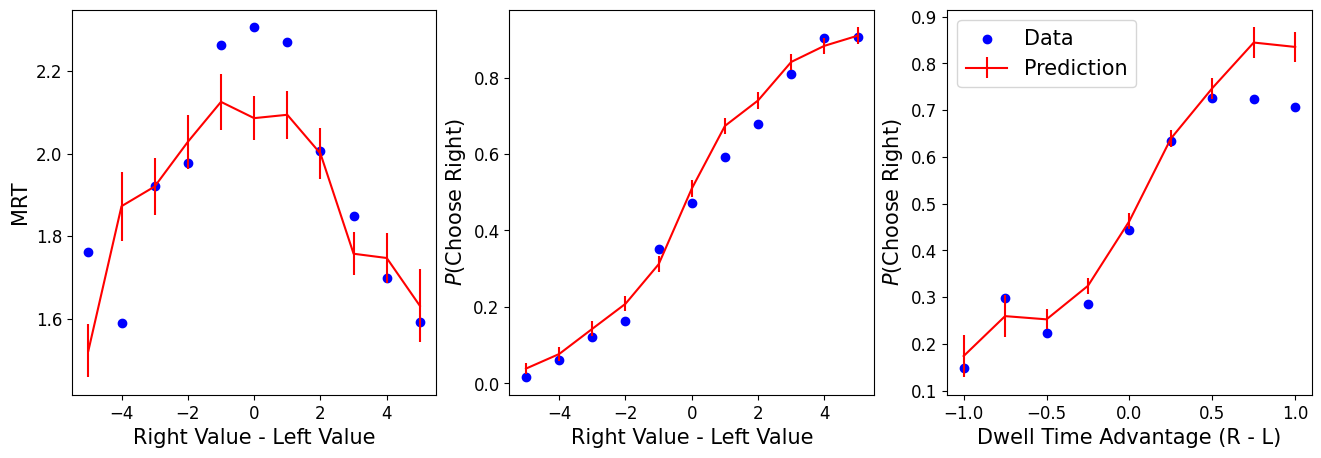

In [13]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1, c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1, 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/kr2010_splitted_postpred.png', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight')
plt.savefig('_plots/kr2010_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

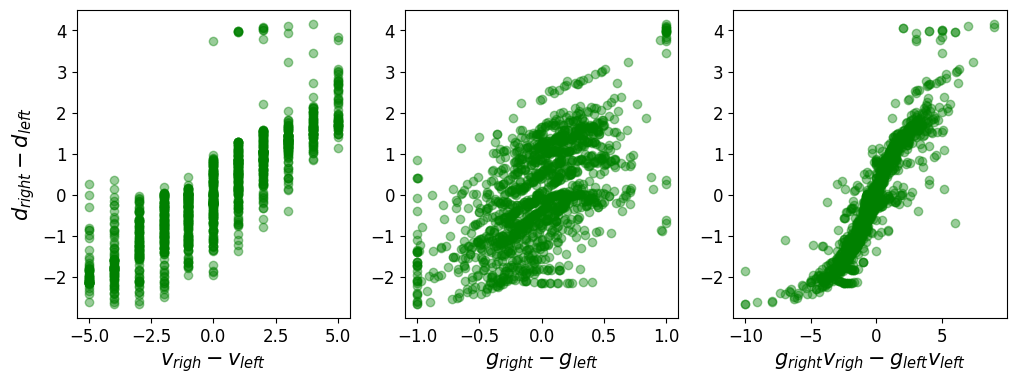

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/kr2010_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');